In [1]:
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [5]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface
from helpers.variables import *
from helpers.variable_interfaces import *
from munch import Munch
from helpers.read_sql import *

from dataclasses import dataclass
from pprint import pprint
import sqlite3
from case_edits.epcase import EneryPlusCaseEditor
from helpers.output_requests import request_sql

import seaborn as sns
from setup.setup import get_case_names, CaseData, retrieve_cases
from setup.plots import *
from setup.data_wrangle import *

import polars as pl
import datetime as dt
from datetime import datetime
from ladybug.dt import DateTime

# # Apply the default theme
# sns.set_theme()

In [6]:
case_data = retrieve_cases()
sample_case  = case_data[0]
case_name, idf, sql, path_to_input, path_to_output = sample_case

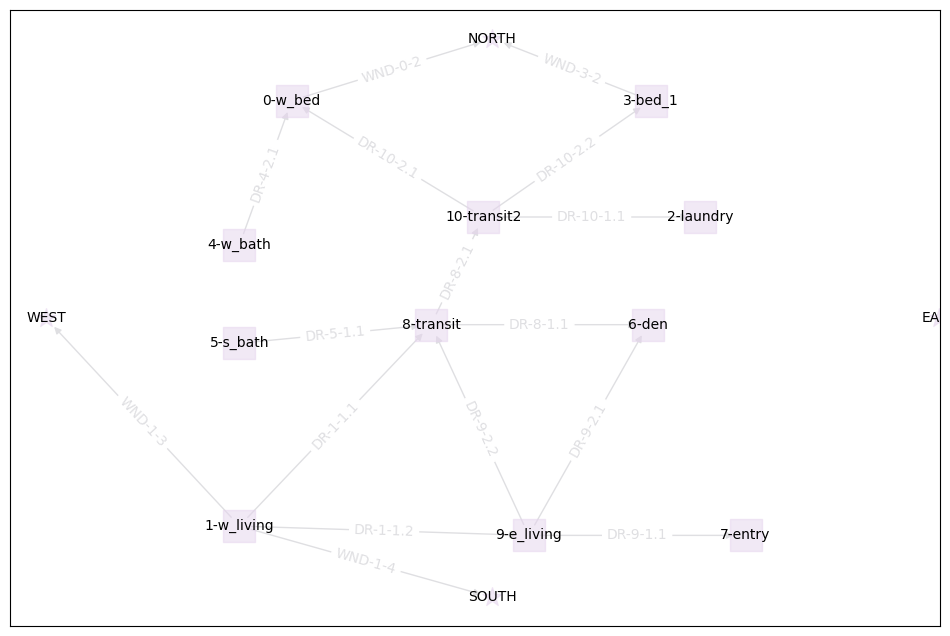

In [7]:
G, pos = create_base_graph(idf, path_to_input)
f = draw_init_graph(idf, G, pos)


In [56]:
G_afn = create_afn_graph(idf, G)

In [41]:
def is_edge_afn_surface(e):
    afn_surfaces = [i.Surface_Name for i in idf.idfobjects["AIRFLOWNETWORK:MULTIZONE:SURFACE"]]
    res = G.edges[e].get("subsurfaces") in afn_surfaces
    return res

In [44]:

edges

[('0-w_bed', 'NORTH'),
 ('1-w_living', '9-e_living'),
 ('1-w_living', '8-transit'),
 ('1-w_living', 'WEST'),
 ('1-w_living', 'SOUTH'),
 ('3-bed_1', 'NORTH'),
 ('8-transit', '6-den'),
 ('8-transit', '10-transit2'),
 ('9-e_living', '8-transit'),
 ('9-e_living', '6-den'),
 ('10-transit2', '3-bed_1'),
 ('10-transit2', '0-w_bed')]

In [46]:
G_afn_maybe = nx.edge_subgraph(G, edges)

In [53]:
assert G_zones.nodes < G_afn_maybe.nodes

In [55]:
assert G_afn_maybe.nodes < G_zones.nodes

AssertionError: 

In [21]:
diff = list(set(G_subsurf.edges).difference(G_zones.edges))
diff

[('1-w_living', 'SOUTH'),
 ('1-w_living', 'WEST'),
 ('0-w_bed', 'NORTH'),
 ('3-bed_1', 'NORTH')]

In [25]:
('0-w_bed', 'NORTH') in diff

True

In [32]:
diff = list(set(G_subsurf.edges).difference(G_zones.edges))
G_remain = nx.edge_subgraph(G, diff)


In [26]:
def is_afn_edge_missing(e1, e2):
    diff = list(set(G_subsurf.edges).difference(G_zones.edges))
    res = (e1, e2) in diff
    return res

G_remain = nx.subgraph_view(G, filter_edge=is_afn_edge_missing)
G_remain.edges

OutEdgeView([('0-w_bed', 'NORTH'), ('1-w_living', 'WEST'), ('1-w_living', 'SOUTH'), ('3-bed_1', 'NORTH')])

TypeError: unsupported operand type(s) for +: 'DiGraph' and 'DiGraph'

In [70]:
set(G.edges).difference(G_subsurf.edges)

{('10-transit2', '2-laundry'),
 ('4-w_bath', '0-w_bed'),
 ('5-s_bath', '8-transit'),
 ('9-e_living', '7-entry')}

In [ ]:
# start by getting nodes
# then edges in between nodes.. 
# so basically 1 and 2 is subgraph induced by nodes -> G_zones
# then have accounted AFN edges, unaccounted afn edges, and non AFN edges. 

# induce graph based on AFN subsurfaces => G_subsurf. Add edges that are in G_subsurf but not in G_zones to G_afn. but new nodes should be distiguised.

# G_not AFN => 

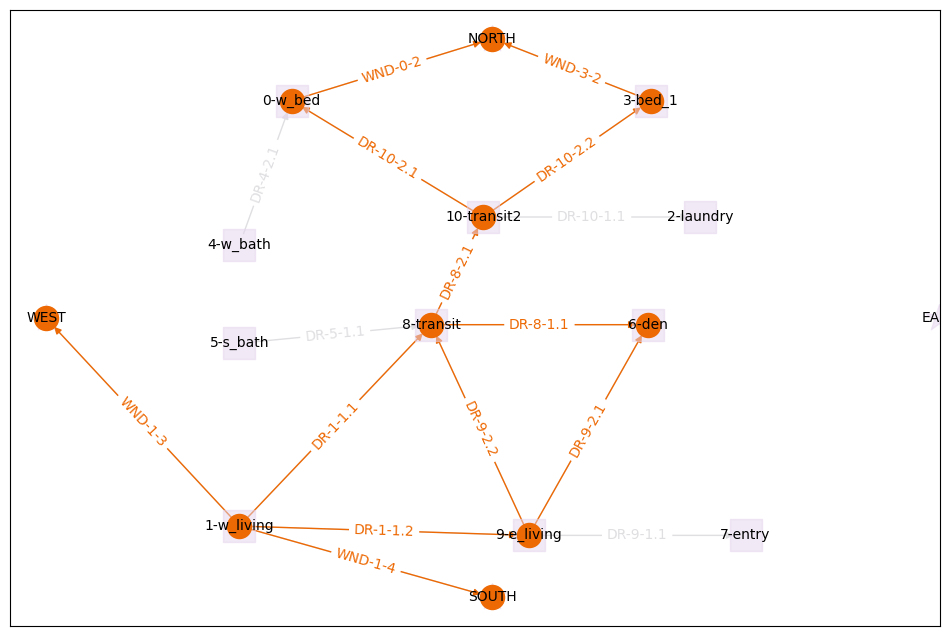

In [60]:
f = draw_init_graph(G, pos)
f1 = draw_afn_graph(G_afn, f, pos)
# f2 = draw_afn_graph(idf, G_remain, f1, pos, "aqua")